### Import Libraries:

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.multiclass import unique_labels
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV

### Load Dataset:

In [4]:
data = pd.read_csv('Text Data.csv')

In [5]:
data['EMOTIONS'].value_counts()

Happy      83007
Neutral    55432
Sad        32182
Anger      27846
Fear        7259
Disgust     5301
Name: EMOTIONS, dtype: int64

### Data Visualization

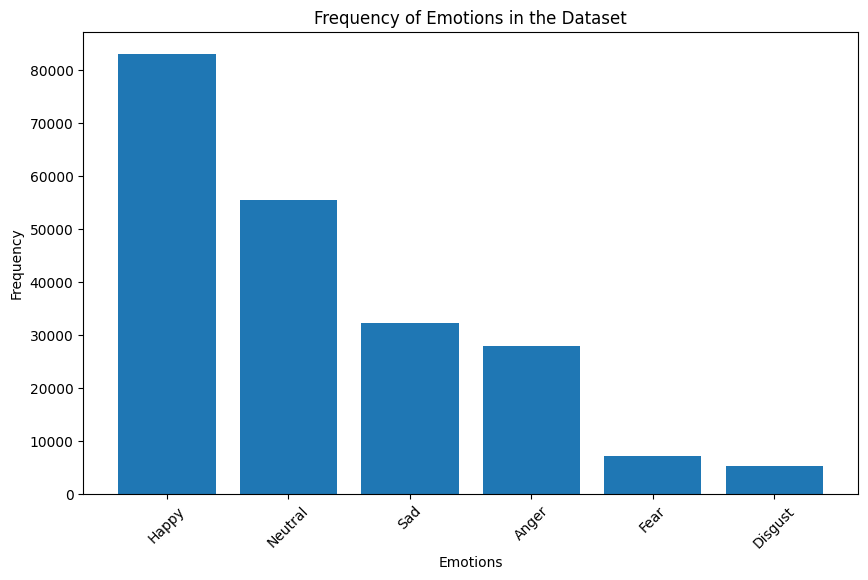

In [6]:
# Bar graph to visualize the frequency of each emotion in dataset
import matplotlib.pyplot as plt

emotions_counts = data['EMOTIONS'].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(emotions_counts.index, emotions_counts.values)
plt.xlabel('Emotions')
plt.ylabel('Frequency')
plt.title('Frequency of Emotions in the Dataset')
plt.xticks(rotation=45) 

plt.show()


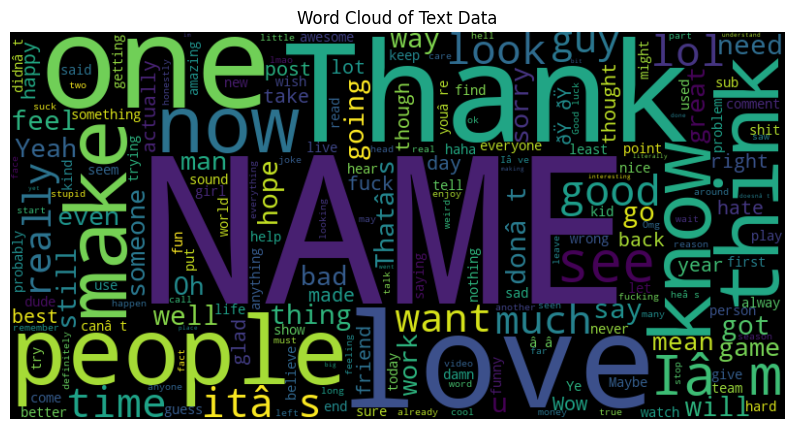

In [8]:
# Word Clouds (for exploring most common words in text data):
from wordcloud import WordCloud

text_data = data['TEXT'].tolist()  
text_combined = ' '.join(text_data)
wordcloud = WordCloud(width=800, height=400).generate(text_combined)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Text Data')
plt.show()

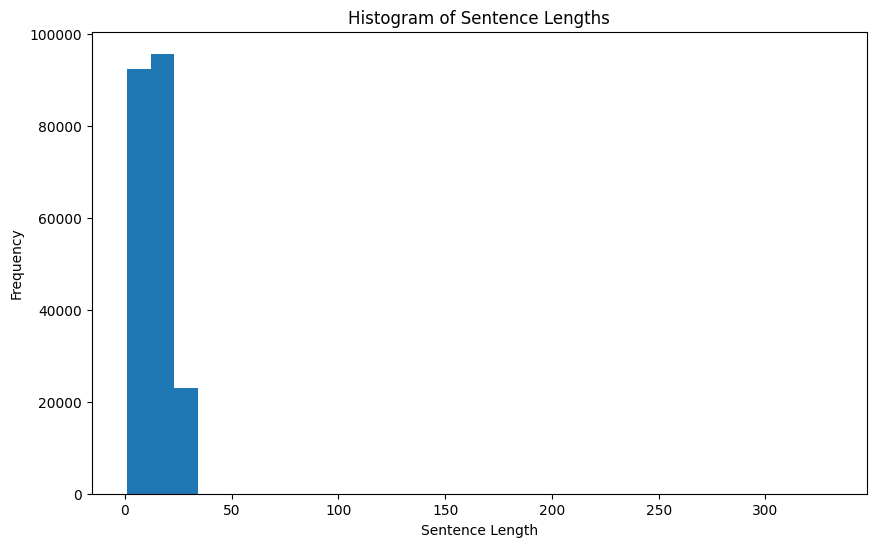

In [9]:
# Histogram of Sentence Lengths (for understanding the distribution of sentence lengths):
sentence_lengths = [len(sentence.split()) for sentence in text_data]

plt.figure(figsize=(10, 6))
plt.hist(sentence_lengths, bins=30)
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.title('Histogram of Sentence Lengths')
plt.show()


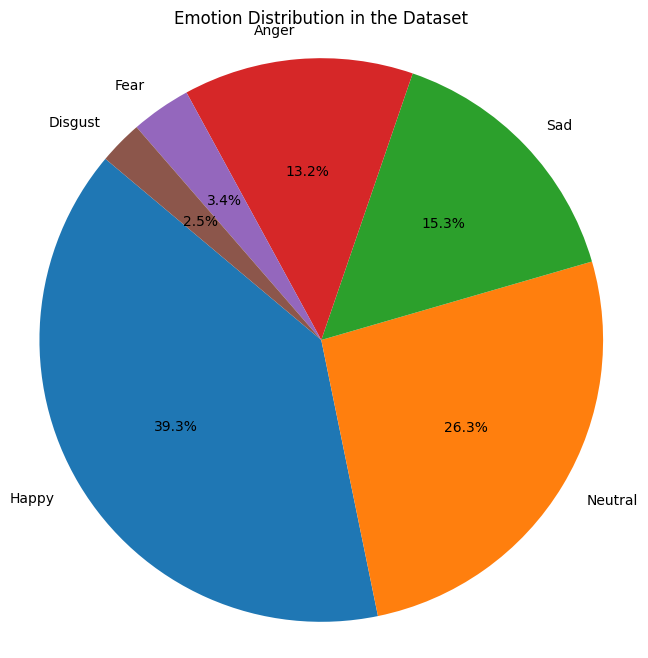

In [18]:
# Pie Chart for Emotion Distribution:
plt.figure(figsize=(8, 8))
plt.pie(emotions_counts.values, labels=emotions_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Emotion Distribution in the Dataset')
plt.axis('equal') 
plt.show()


### Dataset is Imbalanced

#### 1) Technique 1: Upsampling (This is being used here)

In [19]:
# Separate the dataset by emotion
happy = data[data['EMOTIONS'] == 'Happy']
neutral = data[data['EMOTIONS'] == 'Neutral']
sad = data[data['EMOTIONS'] == 'Sad']
anger = data[data['EMOTIONS'] == 'Anger']
fear = data[data['EMOTIONS'] == 'Fear']
disgust = data[data['EMOTIONS'] == 'Disgust']

In [20]:
# Upsample minority classes to match the majority class (Happy)
resampled_neutral = resample(neutral, replace=True, n_samples=len(happy), random_state=42)
resampled_sad = resample(sad, replace=True, n_samples=len(happy), random_state=42)
resampled_anger = resample(anger, replace=True, n_samples=len(happy), random_state=42)
resampled_fear = resample(fear, replace=True, n_samples=len(happy), random_state=42)
resampled_disgust = resample(disgust, replace=True, n_samples=len(happy), random_state=42)


In [21]:
# Combine the resampled dataframes
balanced_data = pd.concat([happy, resampled_neutral, resampled_sad, resampled_anger, resampled_fear, resampled_disgust])

# Shuffle the dataset
data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

### Re-Visualization

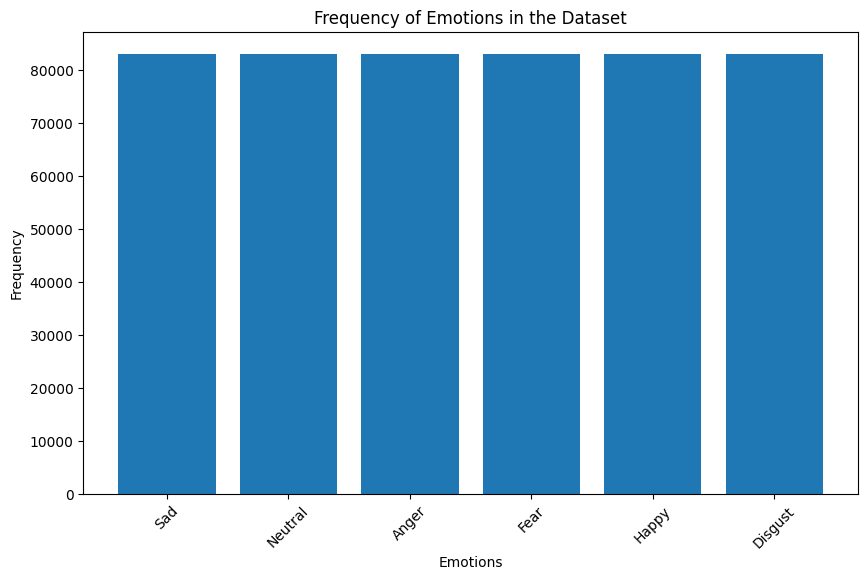

In [22]:
# Bar graph to visualize the frequency of each emotion in dataset
import matplotlib.pyplot as plt

emotions_counts = data['EMOTIONS'].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(emotions_counts.index, emotions_counts.values)
plt.xlabel('Emotions')
plt.ylabel('Frequency')
plt.title('Frequency of Emotions in the Dataset')
plt.xticks(rotation=45)  

plt.show()


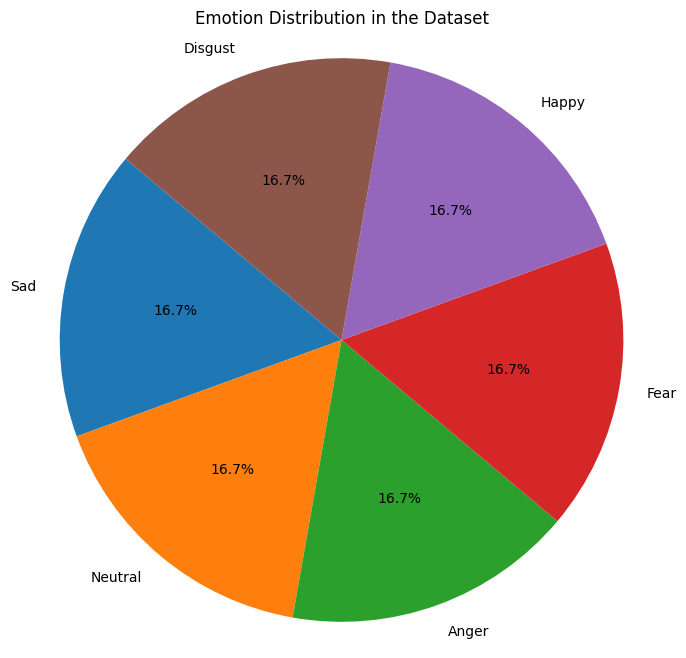

In [23]:
# Pie Chart for Emotion Distribution:
plt.figure(figsize=(8, 8))
plt.pie(emotions_counts.values, labels=emotions_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Emotion Distribution in the Dataset')
plt.axis('equal')  
plt.show()


In [24]:
data['EMOTIONS'].value_counts()

Sad        83007
Neutral    83007
Anger      83007
Fear       83007
Happy      83007
Disgust    83007
Name: EMOTIONS, dtype: int64

#### 2) Technique 2 : Class Weight

In [25]:
# Define the class labels and their frequencies
class_labels = ["Happy", "Neutral", "Sad", "Anger", "Fear", "Disgust"]
class_frequencies = [83007, 55432, 32182, 27846, 7259, 5301]

# Calculate class weights based on class frequencies
total_samples = sum(class_frequencies)
class_weights = {i: total_samples / (len(class_labels) * freq) for i, freq in enumerate(class_frequencies)}

# Create a dictionary with integer class labels as keys
class_weight_dict = {i: weight for i, weight in class_weights.items()}

print("Class Weights Dictionary:", class_weight_dict)

Class Weights Dictionary: {0: 0.4237132611305874, 1: 0.634492110453649, 2: 1.0928831852174092, 3: 1.2630599248246308, 4: 4.845180695228911, 5: 6.63481733006351}


### Preprocess Data

In [27]:

# Split data into input (X) and target (y)
X = data['TEXT'].values
y = data['EMOTIONS'].values

# Encode emotion labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Tokenization and Padding:

In [28]:
# Tokenize the text data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

# Convert text to sequences and pad them to a fixed length
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_sequence_length = 50 
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post')


### Deep Learning Model - ANN

In [29]:
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=max_sequence_length))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 50, 64)            49408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 1366982 (5.21 MB)
Trainable params: 136698

### Train the Model:

In [30]:
epochs = 3  
batch_size = 64
# Convert class weights list to a NumPy array
history = model.fit(X_train_pad, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_pad, y_test))

Epoch 1/3
6226/6226 [==============================] - 527s 84ms/step - loss: 1.7920 - accuracy: 0.1663 - val_loss: 1.7918 - val_accuracy: 0.1659
Epoch 2/3
6226/6226 [==============================] - 775s 124ms/step - loss: 1.7918 - accuracy: 0.1666 - val_loss: 1.7918 - val_accuracy: 0.1669
Epoch 3/3
6226/6226 [==============================] - 527s 85ms/step - loss: 1.7919 - accuracy: 0.1672 - val_loss: 1.7918 - val_accuracy: 0.1655


### Evaluate the Model:

In [31]:

y_pred = model.predict(X_test_pad)  # Generate predictions on the test data


3113/3113 [==============================] - 35s 11ms/step


In [32]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, np.argmax(y_pred, axis=1))
print(f'Accuracy: {accuracy * 100:.2f}%')


Accuracy: 16.55%


In [33]:
report = classification_report(y_test, np.argmax(y_pred, axis=1), target_names=class_labels)

print(report)


              precision    recall  f1-score   support

       Happy       0.00      0.00      0.00     16711
     Neutral       0.00      0.00      0.00     16616
         Sad       0.00      0.00      0.00     16655
       Anger       0.17      1.00      0.28     16483
        Fear       1.00      0.00      0.00     16622
     Disgust       0.00      0.00      0.00     16522

    accuracy                           0.17     99609
   macro avg       0.19      0.17      0.05     99609
weighted avg       0.19      0.17      0.05     99609



c:\Users\VAIBHAV\PycharmProjects\pythonProject\venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\VAIBHAV\PycharmProjects\pythonProject\venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\VAIBHAV\PycharmProjects\pythonProject\venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

### Confusion Matrix

In [34]:
# Compute confusion matrix
cm = confusion_matrix(y_test, np.argmax(y_pred, axis=1)) 

In [35]:
class_labels = label_encoder.classes_

Confusion matrix, without normalization


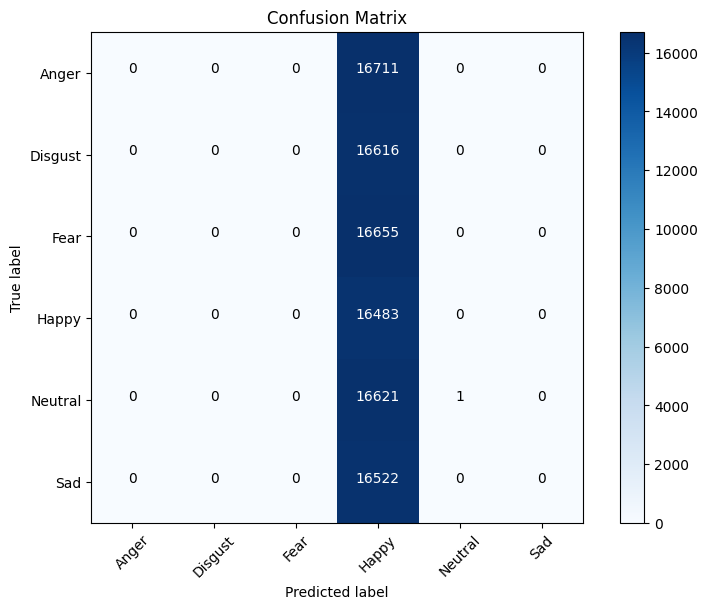

In [36]:

# Plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
plot_confusion_matrix(cm, classes=class_labels, title='Confusion Matrix')

# plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized Confusion Matrix')

plt.show()


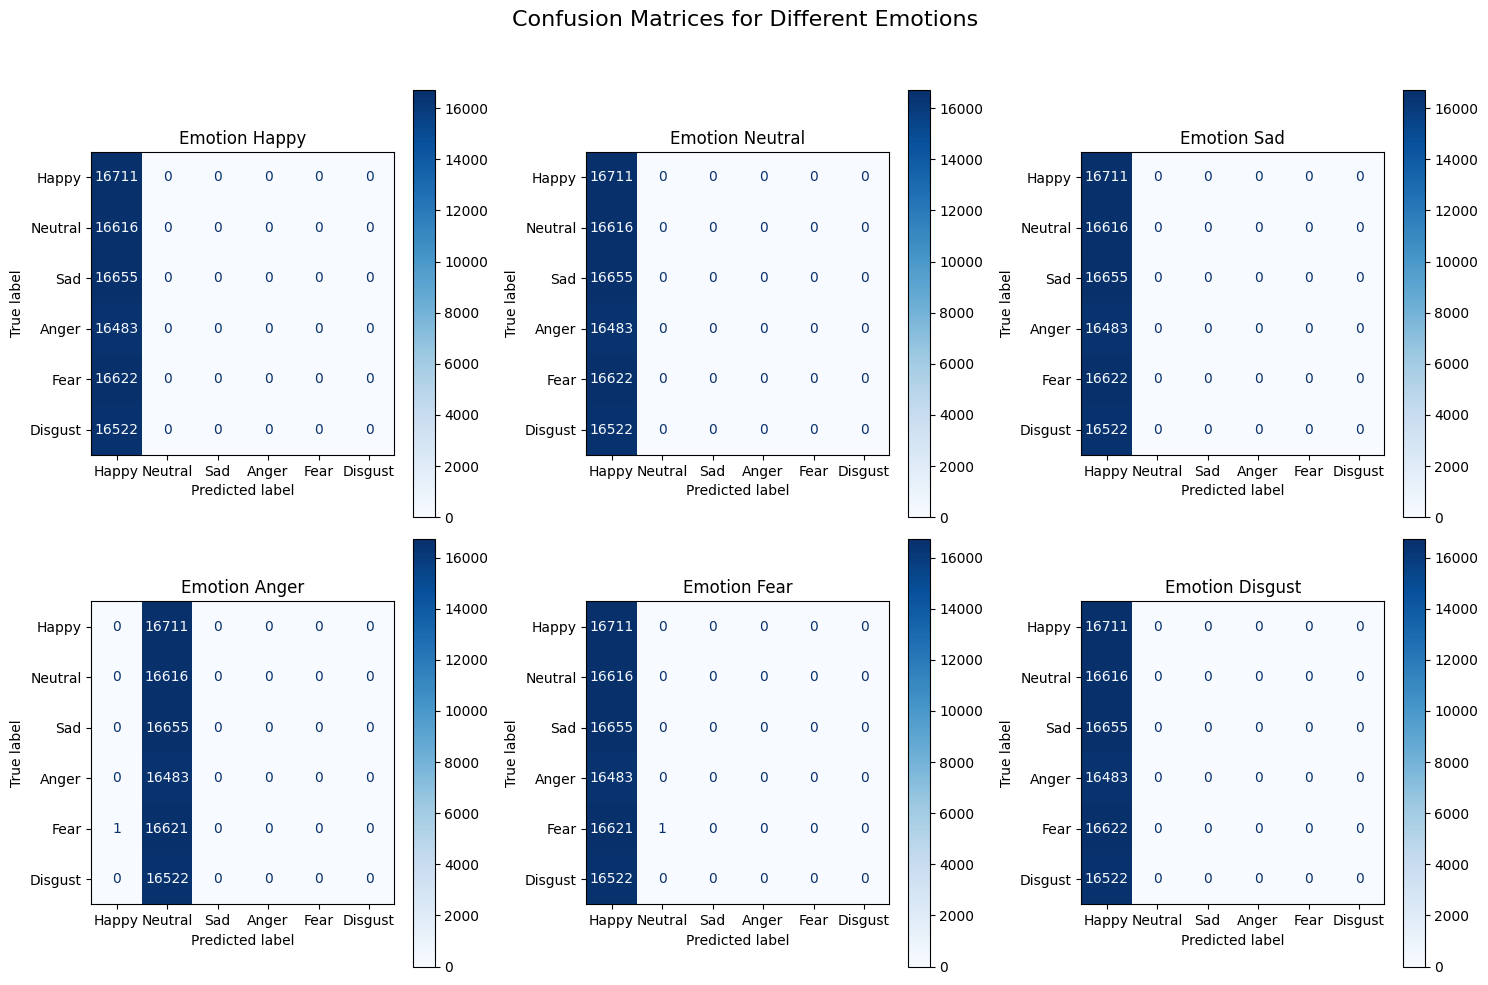

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Define class labels and their corresponding emotion names
class_labels = ["Happy", "Neutral", "Sad", "Anger", "Fear", "Disgust"]
emotion_names = ["Emotion " + label for label in class_labels]

# Create confusion matrices for each emotion
confusion_matrices = []
for i, emotion in enumerate(emotion_names):
    cm = confusion_matrix(y_test, np.argmax(y_pred, axis=1) == i)
    confusion_matrices.append(cm)

# Plot confusion matrices for each emotion
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("Confusion Matrices for Different Emotions", fontsize=16)

for i, ax in enumerate(axes.flatten()):
    if i < len(emotion_names):
        disp = ConfusionMatrixDisplay(confusion_matrices[i], display_labels=class_labels)
        disp.plot(ax=ax, cmap='Blues', values_format='d')
        disp.ax_.set_title(emotion_names[i])

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


### Machine Learning Models

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [39]:
# Create a list of the models
models = [
    LogisticRegression(),
    MultinomialNB(),
    # SVC(),
    RandomForestClassifier(),
    XGBClassifier(),
    GradientBoostingClassifier(),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    AdaBoostClassifier(),
    BaggingClassifier(),
    ExtraTreesClassifier()
]

In [40]:
def train_and_evaluate_models(models, X_train, y_train, X_test, y_test):
    best_model = None
    best_accuracy = 0.0

    for model in models:
        model_name = model.__class__.__name__
        model.fit(X_train, y_train)  # Train the model
        y_pred = model.predict(X_test)  # Make predictions

        # Evaluate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Model: {model_name}")
        print(f"Accuracy: {accuracy:.2f}")
        # Compute confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        class_labels = label_encoder.classes_
        
        # Plot confusion matrix
        def plot_confusion_matrix(cm, classes,
                                normalize=False,
                                title='Confusion matrix',
                                cmap=plt.cm.Blues):
            """
            This function prints and plots the confusion matrix.
            Normalization can be applied by setting `normalize=True`.
            """
            if normalize:
                cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
                print("Normalized confusion matrix")
            else:
                print('Confusion matrix, without normalization')

            plt.figure(figsize=(8, 6))
            plt.imshow(cm, interpolation='nearest', cmap=cmap)
            plt.title(title)
            plt.colorbar()
            tick_marks = np.arange(len(classes))
            plt.xticks(tick_marks, classes, rotation=45)
            plt.yticks(tick_marks, classes)

            fmt = '.2f' if normalize else 'd'
            thresh = cm.max() / 2.
            for i in range(cm.shape[0]):
                for j in range(cm.shape[1]):
                    plt.text(j, i, format(cm[i, j], fmt),
                            horizontalalignment="center",
                            color="white" if cm[i, j] > thresh else "black")

            plt.tight_layout()
            plt.ylabel('True label')
            plt.xlabel('Predicted label')

        # Plot non-normalized confusion matrix
        plot_confusion_matrix(cm, classes=class_labels, title='Confusion Matrix')

        # plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized Confusion Matrix')

        plt.show()

        # Save the best model based on accuracy
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model
    
    print(f"Best Model: {best_model.__class__.__name__} (Accuracy: {best_accuracy:.2f})")


c:\Users\VAIBHAV\PycharmProjects\pythonProject\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: LogisticRegression
Accuracy: 0.18
Confusion matrix, without normalization


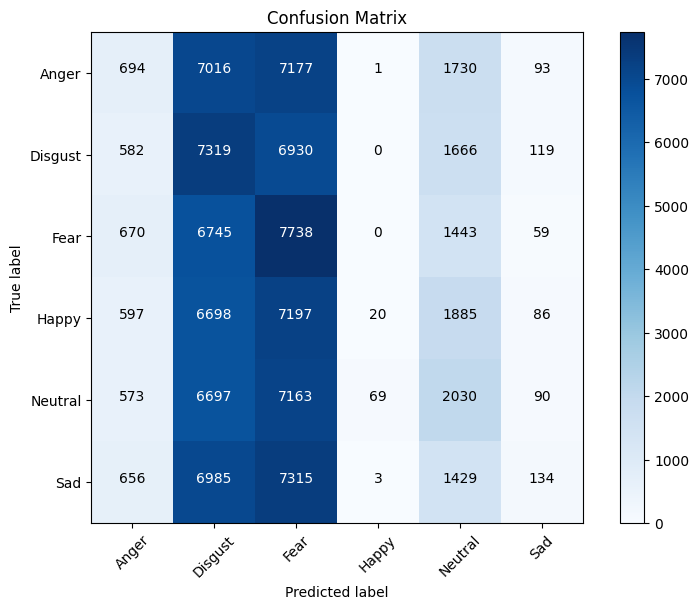

Model: MultinomialNB
Accuracy: 0.19
Confusion matrix, without normalization


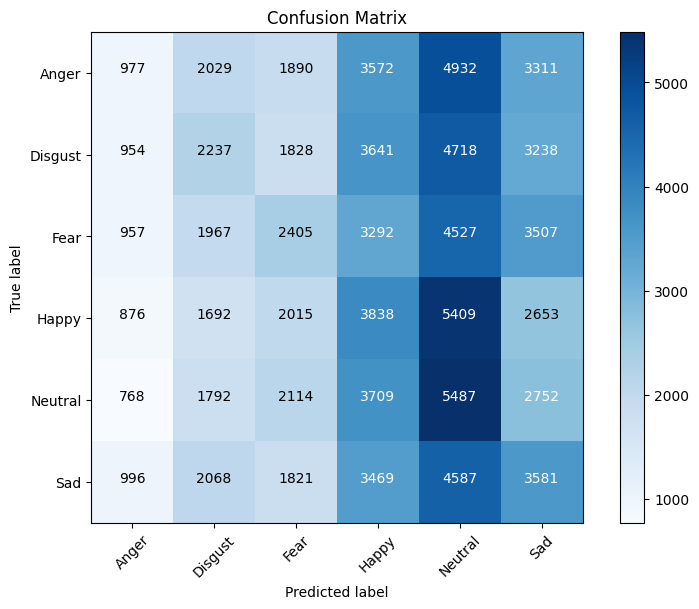

Model: RandomForestClassifier
Accuracy: 0.73
Confusion matrix, without normalization


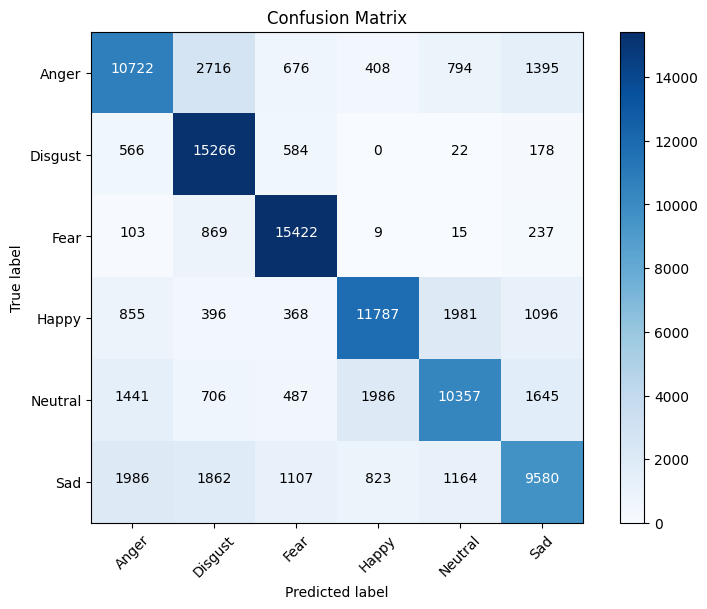

Model: XGBClassifier
Accuracy: 0.52
Confusion matrix, without normalization


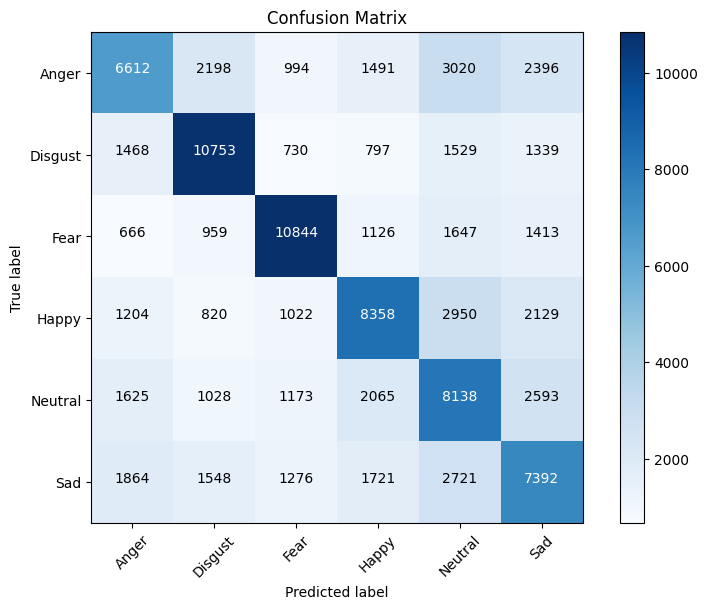

Model: GradientBoostingClassifier
Accuracy: 0.31
Confusion matrix, without normalization


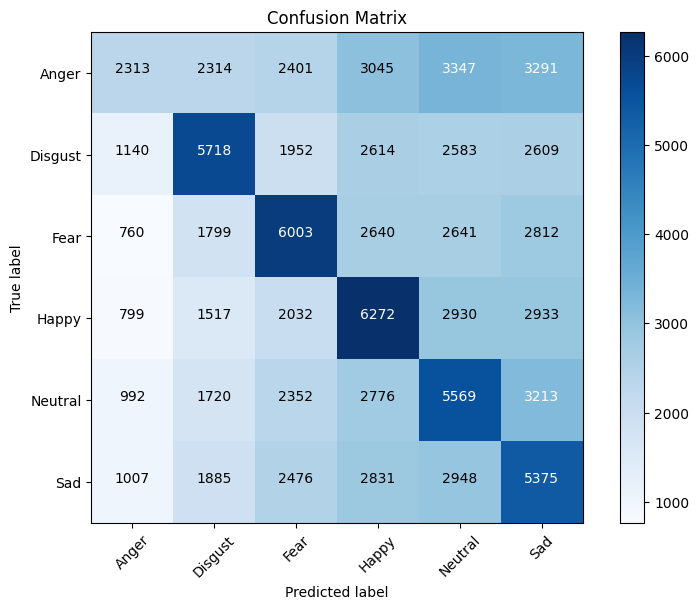

Model: KNeighborsClassifier
Accuracy: 0.65
Confusion matrix, without normalization


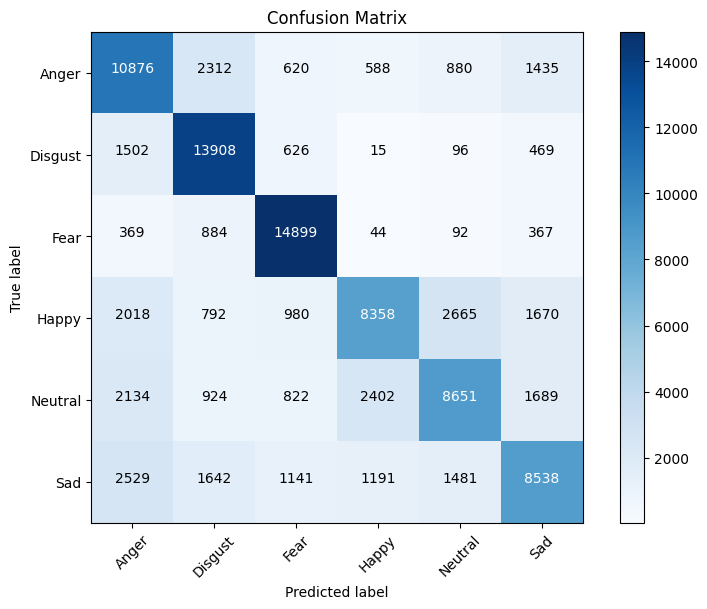

Model: DecisionTreeClassifier
Accuracy: 0.72
Confusion matrix, without normalization


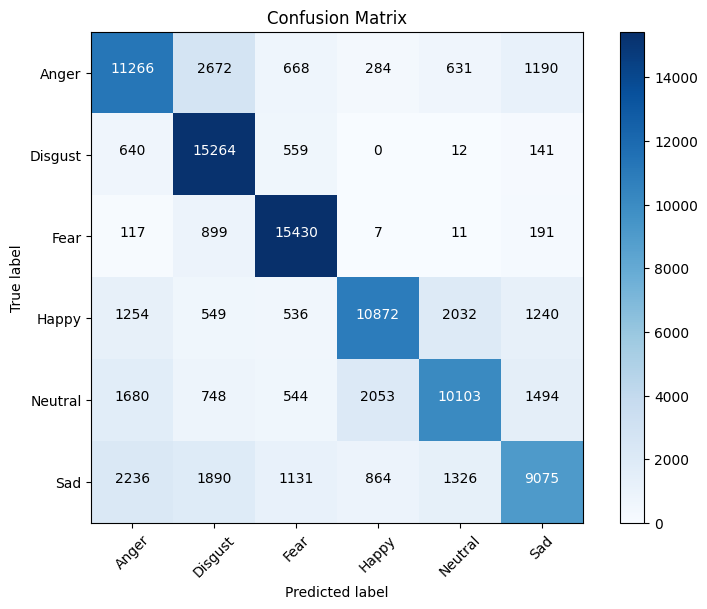

Model: AdaBoostClassifier
Accuracy: 0.23
Confusion matrix, without normalization


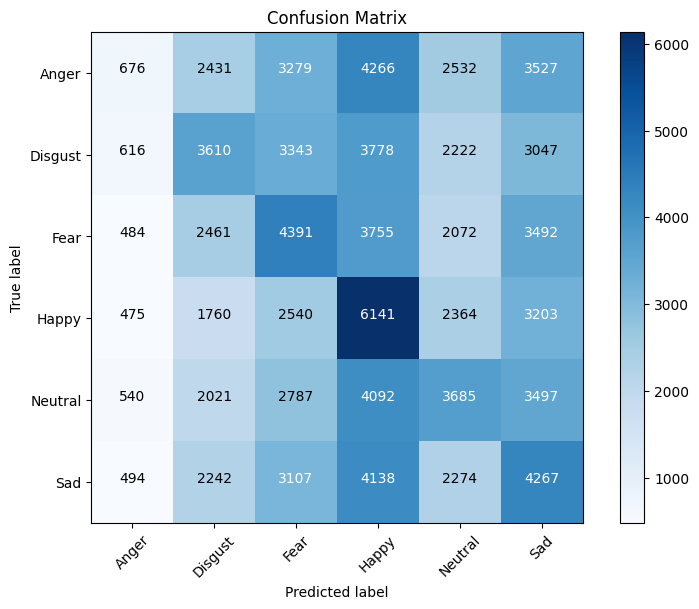

Model: BaggingClassifier
Accuracy: 0.73
Confusion matrix, without normalization


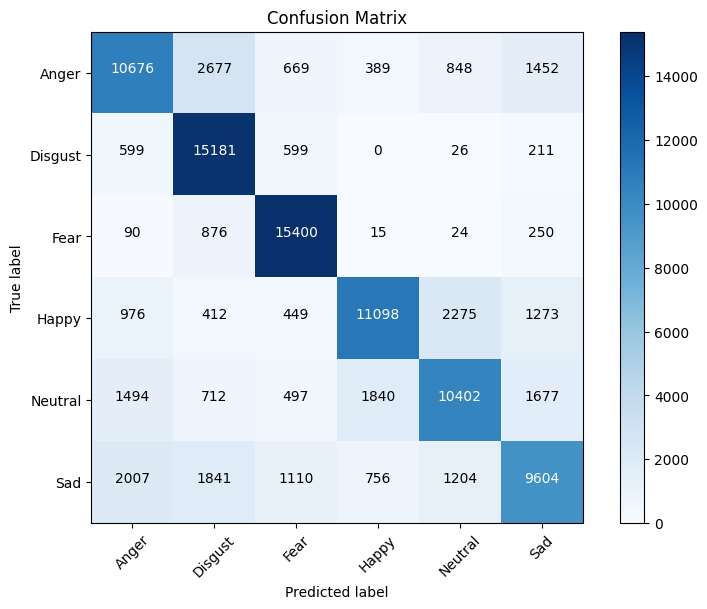

Model: ExtraTreesClassifier
Accuracy: 0.74
Confusion matrix, without normalization


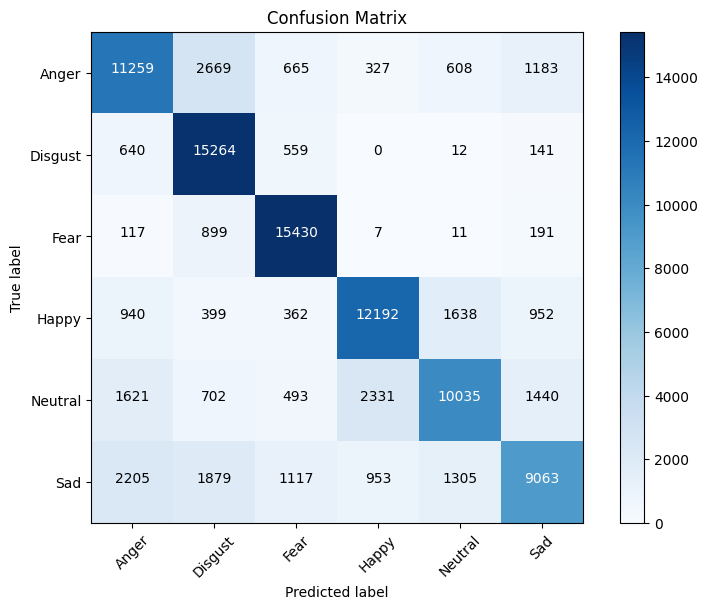

Best Model: ExtraTreesClassifier (Accuracy: 0.74)


In [41]:
# Example usage:
train_and_evaluate_models(models, X_train_pad, y_train, X_test_pad, y_test)

### Top Performing Models
#### 1) Extra Tree Classifier (74%)
#### 2) Bagging Classifier (73%)
#### 3) Decision Tree Clasifier (73%)
#### 4) Random Forest Classifier (72%)

### Making Predictions:

In [ ]:
# Make predictions on new sentences
new_sentences = ["I will kill you"]
new_sequences = tokenizer.texts_to_sequences(new_sentences)
new_padded = pad_sequences(new_sequences, maxlen=max_sequence_length, padding='post')
predictions = best_estimator.predict(new_padded)

# Decode predicted labels back to emotions
predicted_emotions = label_encoder.inverse_transform(predictions)
print(predicted_emotions)
